In [ ]:
# Import libraries...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [ ]:

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


In [ ]:
#DATASET LOADING ...
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5541,6804-GDMOI,Female,0,No,No,61,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,106.6,6428.4,Yes
6567,6215-NQCPY,Male,0,No,No,15,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.7,1566.75,No
4594,4658-HCOHW,Female,0,Yes,Yes,21,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,102.8,2110.15,Yes
7007,2274-XUATA,Male,1,Yes,No,72,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),63.1,4685.55,No
3096,3911-RSNHI,Female,0,Yes,No,71,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),61.4,4310.35,No


In [ ]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [ ]:
df.shape


(7043, 21)

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


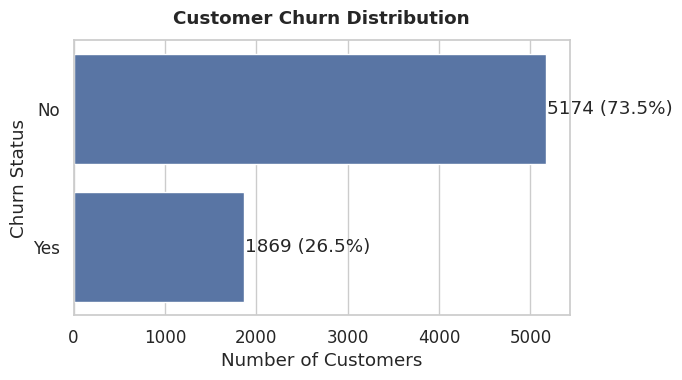

In [ ]:
# Value counts
churn_counts = df["Churn"].value_counts()
total = churn_counts.sum()

# Style
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x=churn_counts.values,
    y=churn_counts.index,
    orient="h"
)

# Annotate count + percentage
for i, value in enumerate(churn_counts.values):
    percentage = (value / total) * 100
    ax.text(
        value + 5,
        i,
        f"{value} ({percentage:.1f}%)",
        va="center"
    )

ax.set_title("Customer Churn Distribution", pad=12, weight="bold")
ax.set_xlabel("Number of Customers")
ax.set_ylabel("Churn Status")

plt.tight_layout()
plt.show()

In [ ]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


DATA PREPROCESSING


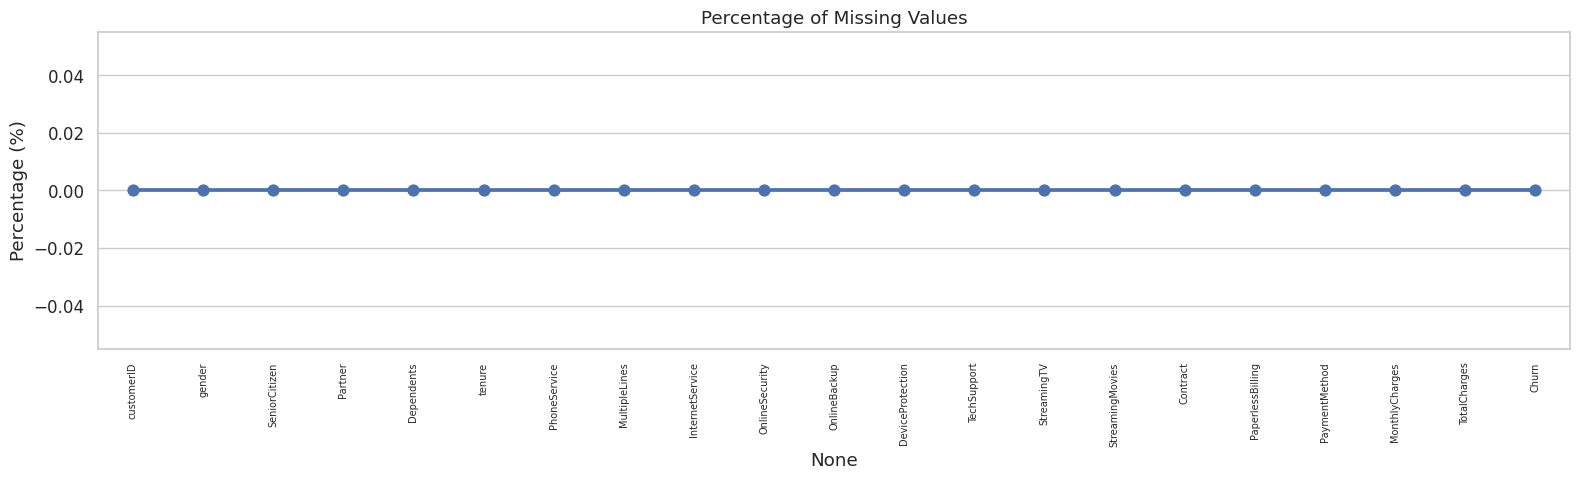

In [ ]:
#Check the Missing Values ...
missing = df.isnull().mean().mul(100)

plt.figure(figsize=(16,5))
sns.pointplot(x=missing.index, y=missing.values)

plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values")
plt.ylabel("Percentage (%)")

plt.tight_layout()
plt.show()


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>CustomerID </b>
</div>

In [ ]:
df.drop('customerID',axis='columns',inplace=True, errors='ignore')

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Gender </b>
</div>

In [ ]:
df['gender'].value_counts()

,count
gender,
Male,3555
Female,3488


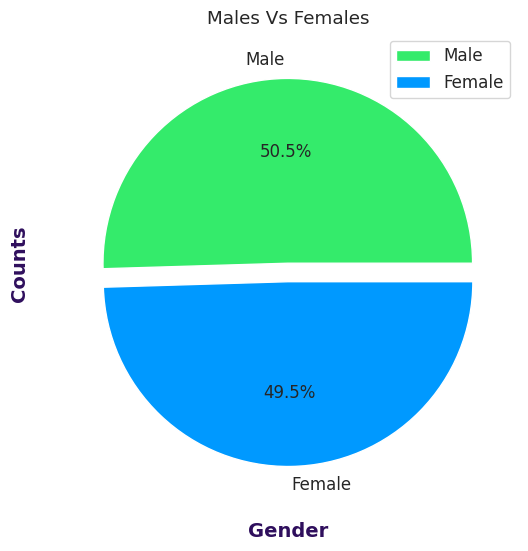

In [ ]:
colors = ["#34eb6b" , "#0099ff"]

plt.figure(figsize = (20, 6))

counts = df["gender"].value_counts()
explode = (0, 0.1)

counts.plot(kind = 'pie', fontsize = 12, colors = colors, explode = explode, autopct = '%.1f%%')
plt.title('Males Vs Females')
plt.xlabel('Gender', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.ylabel('Counts', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.legend(labels = counts.index, loc = "best")
plt.show()

In [ ]:
#Convert 'Male' to 0 and 'Female' to 1
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Partner </b>
</div>

In [ ]:
df['Partner'].value_counts()

,count
Partner,
No,3641
Yes,3402


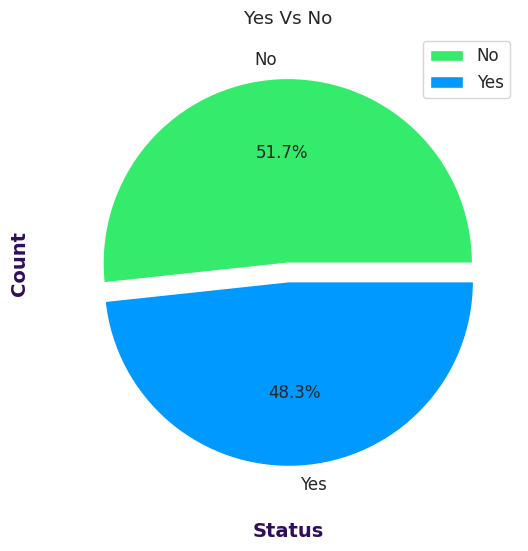

In [ ]:
colors = ["#34eb6b" , "#0099ff"]

plt.figure(figsize = (20, 6))

counts = df["Partner"].value_counts()
explode = (0, 0.1)

counts.plot(kind = 'pie', fontsize = 12, colors = colors, explode = explode, autopct = '%.1f%%')
plt.title('Yes Vs No')
plt.xlabel('Status', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.ylabel('Count', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.legend(labels = counts.index, loc = "best")
plt.show()

In [ ]:
#Convert 'No' to 0 and 'Yes' to 1
df['Partner'] = df['Partner'].map({'No': 0, 'Yes': 1})

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b> Dependents </b>
</div>

In [ ]:
df['Dependents'].value_counts()

,count
Dependents,
No,4933
Yes,2110


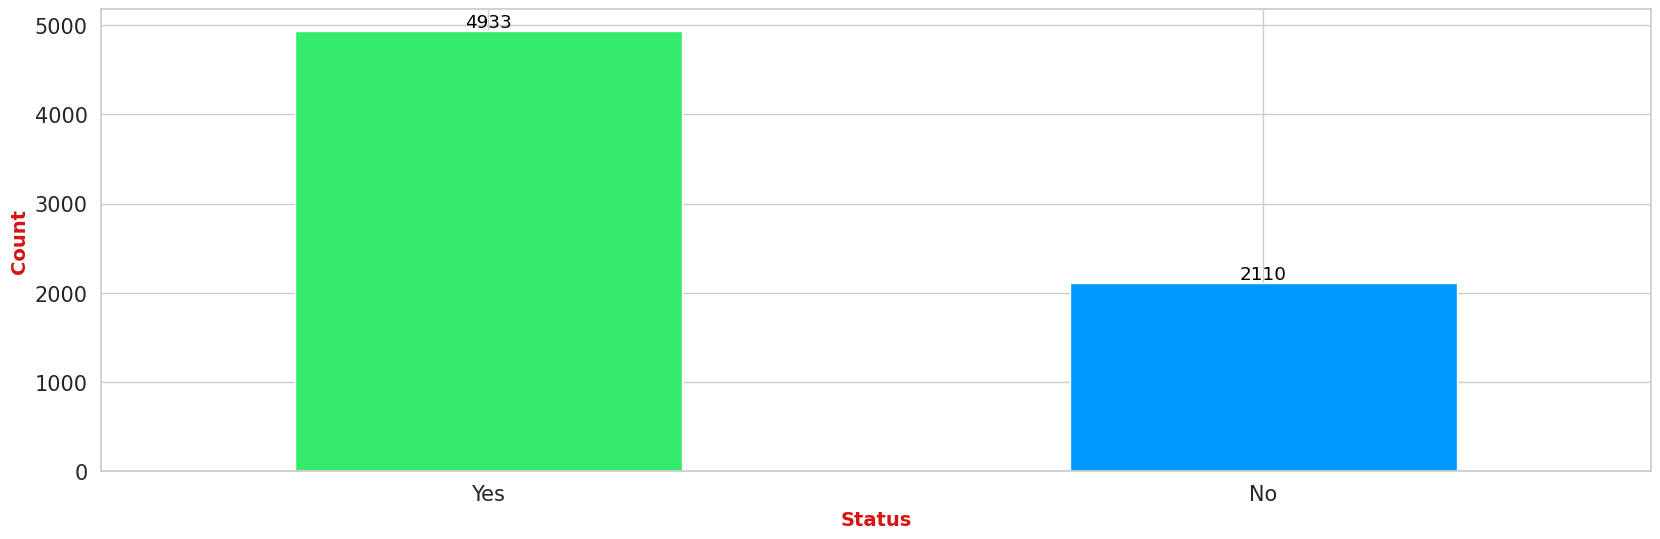

In [ ]:
colors = ["#34eb6b" , "#0099ff"]

plt.figure(figsize = (20, 6))

ax = df["Dependents"].value_counts().plot(kind = 'bar', color = colors[:2], rot = 0)
ax.set_xticklabels(('Yes', 'No'))

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'black')
    ax.tick_params(axis = 'both', labelsize = 15)

plt.xlabel('Status', weight = "bold", color = "#D71313", fontsize = 14)
plt.ylabel('Count', weight = "bold", color = "#D71313", fontsize = 14);

In [ ]:
#Convert 'No' to 0 and 'Yes' to 1
df['Dependents'] = df['Dependents'].map({'No': 0, 'Yes': 1})


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>PhoneService </b>
</div>


In [ ]:
df['PhoneService'].value_counts()

,count
PhoneService,
Yes,6361
No,682


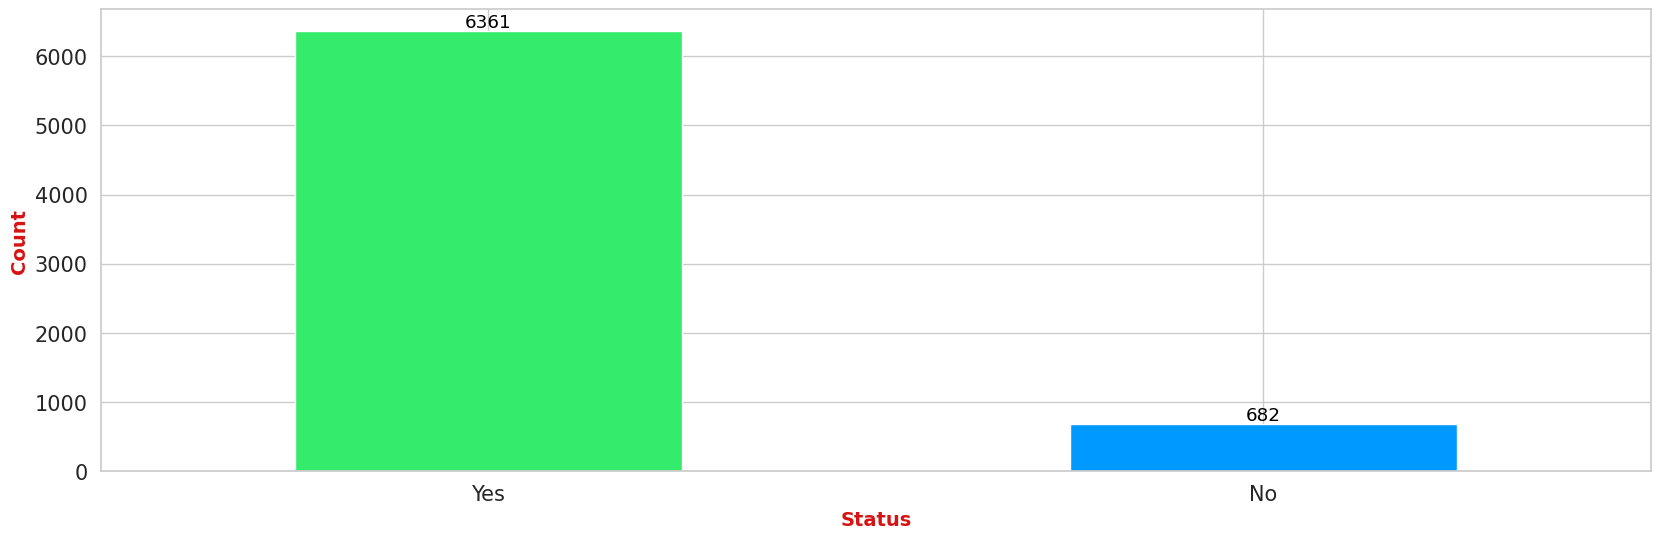

In [ ]:
colors = ["#34eb6b" , "#0099ff"]

plt.figure(figsize = (20, 6))

ax = df["PhoneService"].value_counts().plot(kind = 'bar', color = colors[:2], rot = 0)
ax.set_xticklabels(('Yes', 'No'))

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'black')
    ax.tick_params(axis = 'both', labelsize = 15)

plt.xlabel('Status', weight = "bold", color = "#D71313", fontsize = 14)
plt.ylabel('Count', weight = "bold", color = "#D71313", fontsize = 14);

In [ ]:
#Convert 'No' to 0 and 'Yes' to 1
df['PhoneService'] = df['PhoneService'].map({'No': 0, 'Yes': 1})

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>MultipleLines </b>
</div>

In [ ]:
df['MultipleLines'].value_counts()

,count
MultipleLines,
No,3390
Yes,2971
No phone service,682


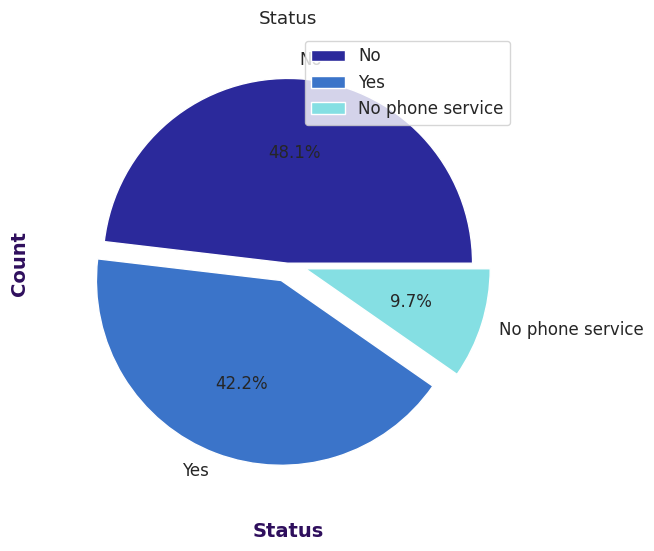

In [ ]:
colors = ["#2B299B" , "#3B74C9" , "#85DFE3"]

plt.figure(figsize = (20, 6))

counts = df["MultipleLines"].value_counts()
explode = (0, 0.1  , 0.1)

counts.plot(kind = 'pie', fontsize = 12, colors = colors, explode = explode, autopct = '%.1f%%')
plt.title('Status')
plt.xlabel('Status', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.ylabel('Count', weight = "bold", color = "#2F0F5D", fontsize = 14, labelpad = 20)
plt.legend(labels = counts.index, loc = "best")
plt.show()

In [ ]:
#Convert 'No phone service' to 0 & Convert 'No' to 0 and 'Yes' to 1
mapping_dict = {'No phone service': 0, 'No': 0, 'Yes': 1}

df['MultipleLines'] = df['MultipleLines'].map(mapping_dict)

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>[InternetService, Contract, PaymentMethod] </b>
</div>

In [ ]:
df.sample(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1629,0,0,1,0,68,1,0,DSL,Yes,Yes,Yes,No,No,Yes,Two year,No,Bank transfer (automatic),70.95,4741.45,No
6060,1,1,0,0,8,1,0,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,87.10,713.6,No
2359,0,0,1,0,33,1,1,DSL,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),72.75,2447.45,No
2964,0,0,1,0,24,1,1,DSL,Yes,No,No,Yes,No,No,One year,Yes,Electronic check,58.35,1346.9,No
1058,0,0,1,1,2,1,0,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),89.55,185.55,Yes
5174,1,0,0,0,7,1,0,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.30,526.7,Yes
5597,0,1,0,0,22,1,1,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),90.50,1910.6,Yes
3372,0,1,0,0,57,1,1,Fiber optic,No,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),104.90,5913.95,No
4791,0,0,1,0,3,1,0,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),20.00,49.65,No
648,1,1,0,0,2,1,1,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,No,Electronic check,89.50,161.5,Yes


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Using sklearn LabelEncoder </b>
</div>

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df.InternetService = le.fit_transform(df.InternetService)
df.Contract = le.fit_transform(df.Contract)
df.PaymentMethod = le.fit_transform(df.PaymentMethod)

In [ ]:
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3836,1,0,1,0,64,1,1,0,No,No,Yes,Yes,No,No,1,No,0,58.35,3756.45,No
66,0,0,1,0,47,1,1,1,No,Yes,No,No,No,No,1,Yes,2,78.90,3650.35,No
3461,1,0,1,1,55,1,0,0,Yes,Yes,No,No,No,No,0,No,2,55.70,3131.8,No
1424,1,0,0,1,48,1,0,2,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,No,3,19.95,936.7,No
590,0,0,1,0,72,1,1,1,Yes,No,Yes,Yes,Yes,Yes,2,Yes,1,111.90,8071.05,No


<div style = 'border : 3px solid non; background-color:#e3e3e3
              ;font-family:Times New Roman;
              font-size:110%;padding:10px'>

    
To avoid redundancy, One function to pre-process them all


In [ ]:
df.replace('No internet service','No',inplace=True)
df.replace('No phone service','No',inplace=True)

In [ ]:
yes_no_columns = [
    'Partner','Dependents','PhoneService','MultipleLines',
    'OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies',
    'PaperlessBilling','Churn'
]

df[yes_no_columns] = df[yes_no_columns].replace({'Yes': 1, 'No': 0})


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>TotalCharges</b>
</div>

Check the Null Values ...

In [ ]:
#tot charges is in object and it should be numeric thus
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].dtype


dtype('float64')

In [ ]:
df.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [ ]:
df.loc[df['TotalCharges'].isnull() == True]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,1,0,1,1,0,0,0,0,1,0,1,1,1,0,2,1,0,52.55,NaN,0
753,0,0,0,1,0,1,0,2,0,0,0,0,0,0,2,0,3,20.25,NaN,0
936,1,0,1,1,0,1,0,0,1,1,1,0,1,1,2,0,3,80.85,NaN,0
1082,0,0,1,1,0,1,1,2,0,0,0,0,0,0,2,0,3,25.75,NaN,0
1340,1,0,1,1,0,0,0,0,1,1,1,1,1,0,2,0,1,56.05,NaN,0
3331,0,0,1,1,0,1,0,2,0,0,0,0,0,0,2,0,3,19.85,NaN,0
3826,0,0,1,1,0,1,1,2,0,0,0,0,0,0,2,0,3,25.35,NaN,0
4380,1,0,1,1,0,1,0,2,0,0,0,0,0,0,2,0,3,20.00,NaN,0
5218,0,0,1,1,0,1,0,2,0,0,0,0,0,0,1,1,3,19.70,NaN,0
6670,1,0,1,1,0,1,1,0,0,1,1,1,1,0,2,0,3,73.35,NaN,0


In [ ]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.shape


(7043, 20)

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>StandardScaler</b>
</div>

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


In [ ]:
df[cols_to_scale].sample(5)

,tenure,MonthlyCharges,TotalCharges
3720,0.392090,-0.339395,0.076435
556,-1.277445,-1.491021,-0.998635
5049,-1.277445,-1.481050,-0.998502
6328,1.532261,0.830510,1.803570
2268,0.310650,-1.467755,-0.642184


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>DATASET FINAL SUMMARY </b>
</div>

In [ ]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = (df.isna().sum())/len(df)
    summary_df['unique'] = df.nunique().values
    summary_df['count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,unique,count
gender,int64,0,0.000000,2,7043
SeniorCitizen,int64,0,0.000000,2,7043
Partner,int64,0,0.000000,2,7043
Dependents,int64,0,0.000000,2,7043
tenure,float64,0,0.000000,73,7043
PhoneService,int64,0,0.000000,2,7043
MultipleLines,int64,0,0.000000,2,7043
InternetService,int64,0,0.000000,3,7043
OnlineSecurity,int64,0,0.000000,2,7043
OnlineBackup,int64,0,0.000000,2,7043


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Determine Predictor & Target</b>
</div>

In [ ]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

In [ ]:
X.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4436,1,0,0,1,-0.544478,1,0,0,1,1,1,0,0,0,0,1,2,-0.138318,-0.434468
4338,0,1,0,0,-1.114563,0,0,0,0,0,1,1,1,0,0,0,1,-0.643504,-0.912612
4033,0,0,1,1,1.410099,1,0,0,1,1,0,1,0,0,1,0,3,-0.156598,0.755872


In [ ]:
y.sample(3)

,Churn
1147,0
1981,1
6162,0


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>DATA SPLIT ...</b>
</div>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
X_train.shape

(5634, 19)

In [ ]:
X_test.shape

(1409, 19)

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>BUILDING THE MODEL </b>
</div>

In [ ]:
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


In [ ]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred=model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
model.score(X_test,y_test)

0.7963094393186657

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC Score: 0.8350112376966597


<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Handling Imbalanced Data </b>
</div>

In [ ]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X, y)

In [ ]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)
model_dt_smote=model = XGBClassifier(n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


In [ ]:
model_dt_smote.fit(xr_train,yr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(model_score_r)
print(classification_report(yr_test, yr_predict))


0.9515384615384616
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       576
           1       0.95      0.96      0.96       724

    accuracy                           0.95      1300
   macro avg       0.95      0.95      0.95      1300
weighted avg       0.95      0.95      0.95      1300



In [ ]:
cm = (confusion_matrix(yr_test, yr_predict))
print(cm)

[[541  35]
 [ 28 696]]


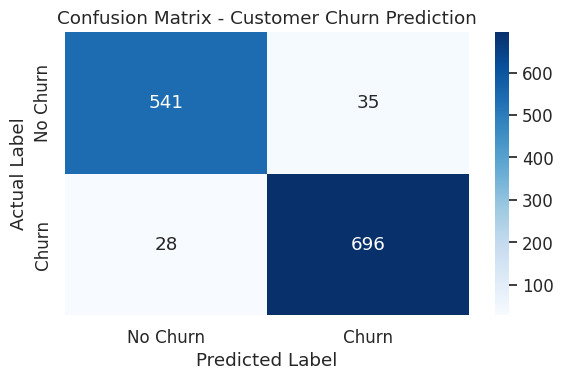

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Customer Churn Prediction")

plt.tight_layout()
plt.show()

<div style="padding:10px;
            color:#30efe0;
            background-color:#000000;
            margin:50px;
            font-size:130%;
            display:fill;
            border-radius:10px;
            border-style: ridge;
            border-color: #9fc5e8;
            overflow:hidden;
            font-weight:400;
            "><b>Pickling the model..</b>
</div>

In [ ]:
filename = 'model.sav'
pickle.dump(model_dt_smote, open(filename, 'wb'))
load_model = pickle.load(open(filename, 'rb'))
model_score_r1 = load_model.score(xr_test, yr_test)
model_score_r1


0.9515384615384616